**import Required libraries :**


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**Tracking colorful objects :**

We have seen that background subtraction can be an effective technique for detecting
moving objects; however, we know that it has some inherent limitations. Notably, it
assumes that the current background can be predicted based on past frames. This
assumption is fragile. For example, if the camera moves, the entire background model
could suddenly become outdated. Thus, in a robust tracking system, it is important to build
some kind of model of foreground objects rather than just the background.
Once we have detected a moving object (by background subtraction or other means), we
would like to describe the object in a way that distinguishes it from other moving objects. In
this way, we can continue to identify and track the object even if it crosses paths with
another moving object. A color histogram may serve as a sufficiently unique description.
Essentially, an object's color histogram is an estimate of the probability distribution of pixel
colors in the object. For example, the histogram could indicate that each pixel in the object is
10% likely to be blue. The histogram is based on the actual colors observed in the object's
region of a reference image.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 21-23


In [39]:
# Create a background subtractor using the MOG2 method with shadow detection enabled.
bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

# Define the kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# Open the video file for reading
cap = cv2.VideoCapture("videos/car_racing.mp4")
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Apply background subtraction to get the foreground mask
    fg_mask = bg_subtractor.apply(frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 1000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('MOG', fg_mask)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(1)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

**Mouse Callback Function (click_and_crop):**

This code uses the OpenCV library to perform interactive cropping on a video frame. It allows the user to click and drag to define a region of interest (ROI) in a video frame and save it as a separate image.

• `refPt` and `sel_rect_endpoint` are two lists that will be used to store the reference points for the region of interest and the selected rectangle's endpoints.

• `cropping` is a boolean variable that indicates whether the cropping operation is currently being performed.

• `click_and_crop(event, x, y, flags, param)` is a callback function that will be called whenever a mouse event occurs. It handles the logic for cropping the region of interest.

• When the left mouse button is clicked `(cv2.EVENT_LBUTTONDOWN)`, it records the starting coordinates (x, y) and sets cropping to True.

• When the left mouse button is released `(cv2.EVENT_LBUTTONUP)`, it records the ending coordinates (x, y), sets cropping to False, and draws a rectangle around the selected region.

• cv2.setMouseCallback`('frame', click_and_crop)` sets the mouse callback function, so click_and_crop will be called whenever a mouse event occurs on the window named `'frame'`.

This code essentially allows interactive cropping of a video frame and provides options to reset, save, and quit the program.

In [2]:
# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
sel_rect_endpoint = []
cropping = False

def click_and_crop(event, x, y, flags, param):
    
    # grab references to the global variables
    global refPt, cropping
    
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True

    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False
        
        # draw a rectangle around the region of interest
        cv2.rectangle(frame, refPt[0], refPt[1], (0, 0, 0), 2)
        cv2.imshow('frame', frame)

# Load a video file and extract one frame
cap = cv2.VideoCapture("videos/car_racing.mp4")

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

clone = frame.copy()
cv2.namedWindow('frame')
cv2.setMouseCallback('frame', click_and_crop)

while True:
    # display the image and wait for a keypress
    cv2.imshow('frame', frame)
    key = cv2.waitKey(1) & 0xFF

    # if the 'r' key is pressed, reset the cropping region
    if key == ord('r'):
        frame = clone.copy()

    # if the 's' key is pressed, save the cropped region
    elif key == ord('s'):
        if len(refPt) == 2:
            roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
            cv2.imwrite('roi.jpg', roi)
            print("Cropped ROI saved as 'roi.jpg'.")

    # if the 'q' key is pressed, break from the loop
    elif key == ord('q'):
        break
        
# if there are two reference points, then crop the region of interest
# from the image and display it        
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow('ROI', roi)
    cv2.waitKey(0)
    
# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


Cropped ROI saved as 'roi.jpg'.


---
By the 20th frame, we assume that the exposure is good; therefore, we can extract
an accurate histogram of a region of interest. The following code defines the
bounds of the **region of interest (ROI):**


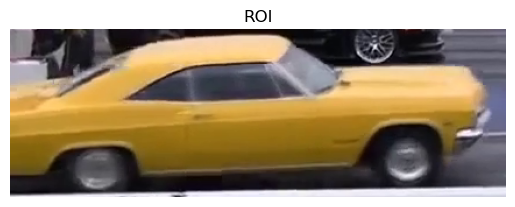

In [3]:
cap = cv2.VideoCapture("videos/car_racing.mp4")

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

# Define an initial tracking window for a specific object.
frame_h, frame_w = frame.shape[:2]
w = frame_w // 3  # Adjust the width of the window
h = frame_h // 5  # Adjust the height of the window
x = 10  # Adjust the x-coordinate of the top-left corner of the window
y = 400  # Adjust the y-coordinate of the top-left corner of the window
track_window = (x, y, w, h)

roi = frame[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title('ROI')
plt.axis('off')
plt.show()

---

# cv2.calcHist : 

`cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])`


• **images:** The input image (or images). It can be a single image or a list of images.

• **channels:** The list of color channels you want to create histograms for. For example, [0] for grayscale, and

For **BGR** channels:

`[0]` for calculating the histogram of the blue channel **(Blue)**

`[1]` for calculating the histogram of the green channel **(Green)**

`[2]` for calculating the histogram of the red channel **(Red)**


• **mask:** A mask to specify the region of the image that participates in the histogram calculation.(Optional)

• **histSize:** The number of bins or levels in the histogram for each channel.

• **ranges:** The range of each bin in each channel. For example, [0, 256] for BGR channels.

• **hist:** The resulting histogram array (Optional).

• **accumulate:** A flag that indicates whether to accumulate the previous histogram or not.(Optional)

Using these parameters, we can calculate different histograms and use them for histogram back-projection.


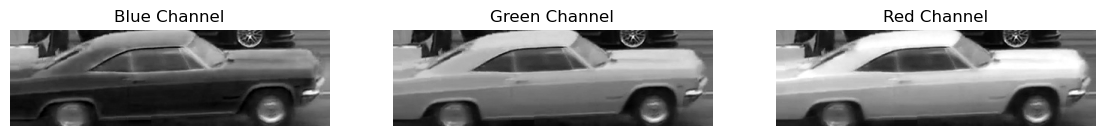

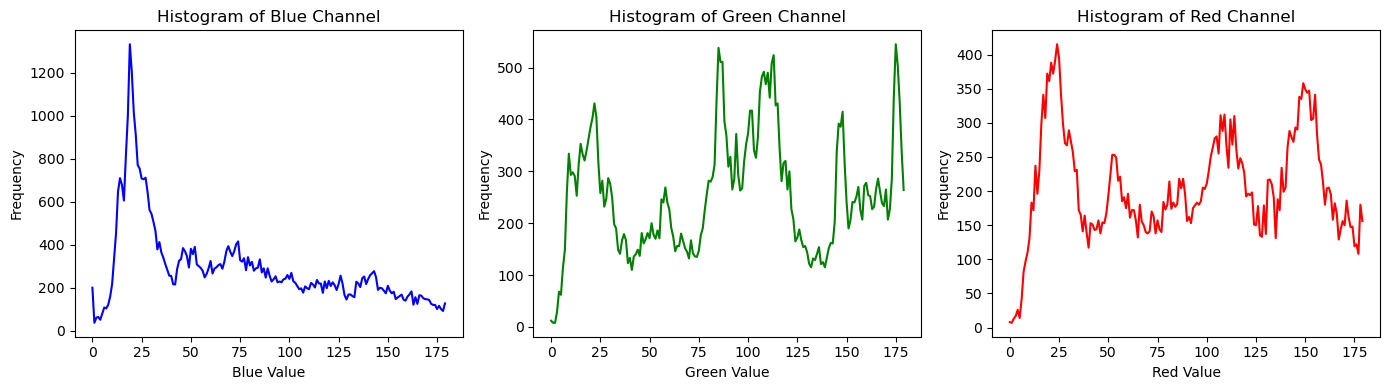

In [3]:
# Read roi image
roi = cv2.imread("roi.jpg")

# Splitting the image into R, G, and B channels
b, g, r = cv2.split(roi)

# Displaying the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.imshow(b, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(g, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(r, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

plt.show()

# Define a mask (optional, currently set to None)
mask = None

# Calculating histograms for the R, G, and B channels
b_hist = cv2.calcHist([roi], [0], mask, [180], [0, 180])
g_hist = cv2.calcHist([roi], [1], mask, [180], [0, 180])
r_hist = cv2.calcHist([roi], [2], mask, [180], [0, 180])

# Displaying the histograms of the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(b_hist, color='b')
plt.title('Histogram of Blue Channel')
plt.xlabel('Blue Value')
plt.ylabel('Frequency') 

plt.subplot(132)
plt.plot(g_hist, color='g')
plt.title('Histogram of Green Channel')
plt.xlabel('Green Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.plot(r_hist, color='r')
plt.title('Histogram of Red Channel')
plt.xlabel('Red Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

---
`cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])`

**channels:** The list of color channels you want to create histograms. 

For **HSV** channels:

•`[0]` for calculating the histogram of the hue channel **(Hue)**

•`[1]` for calculating the histogram of the saturation channel **(Saturation)**

•`[2]` for calculating the histogram of the value channel **(Value)**

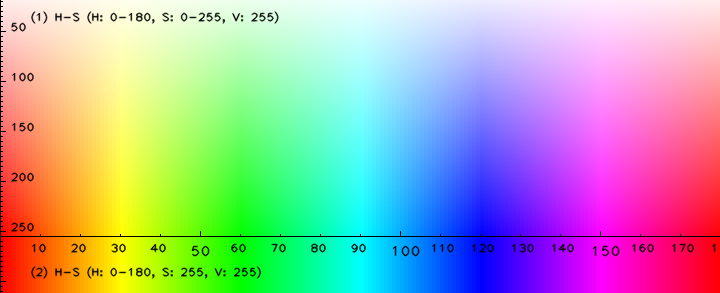

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 23-24


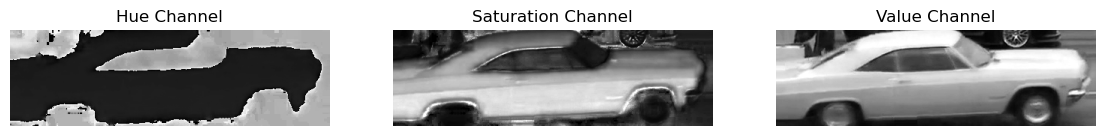

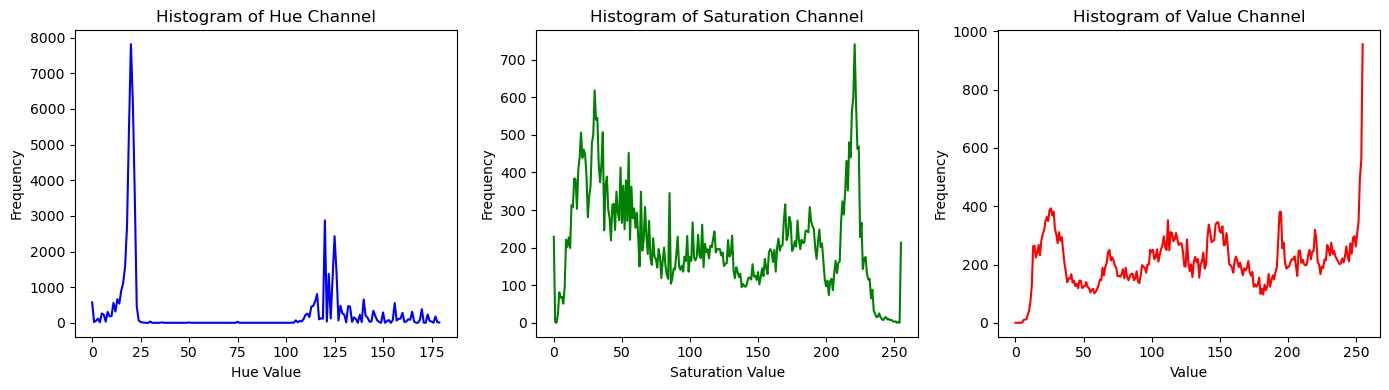

In [4]:
# Convert ROI to HSV color space
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Split the HSV image into H, S, and V channels
h, s, v = cv2.split(hsv_roi)

# Display the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.imshow(h, cmap='gray')
plt.title('Hue Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(s, cmap='gray')
plt.title('Saturation Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(v, cmap='gray')
plt.title('Value Channel')
plt.axis('off')

plt.show()

# Define a mask (optional, currently set to None)
mask = None

# Calculate histograms for the H, S, and V channels
h_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
s_hist = cv2.calcHist([hsv_roi], [1], mask, [256], [0, 256])
v_hist = cv2.calcHist([hsv_roi], [2], mask, [256], [0, 256])

# Display the histograms
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(h_hist, color='b')
plt.title('Histogram of Hue Channel')
plt.xlabel('Hue Value')
plt.ylabel('Frequency') 

plt.subplot(132)
plt.plot(s_hist, color='g')
plt.title('Histogram of Saturation Channel')
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.plot(v_hist, color='r')
plt.title('Histogram of Value Channel')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

---
# cv2.calcBackProject :

Back Projection is an image processing technique used to identify regions in an image that are likely to contain a specific feature or object. It accomplishes this by comparing the color or intensity distribution of pixels in an image with a pre-defined model or reference histogram.

`cv2.calcBackProject(images, channels, hist, ranges, scale[, dst])` 

• **images:** The input image (or images). It can be a single image or a list of images.

• **channels:** This parameter is the list of the indices of the channels used to compute the back projection. For example, channels=`[0]` means that only the first channel (channel with index 0) is used.

• **hist:** This parameter is the histogram that we want to back project. It should be a 1D or 2D histogram.

• **ranges:** This parameter is the range of values for each dimension. It is a list of the ranges for each channel.

• **scale:** This parameter is a scaling factor applied to the back projection. It adjusts the overall intensity of the output.

• **dst:** This is the optional output destination. If not specified, a new array is created.

The function returns the back-projected image.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 25-27



 ---
# MeanShift :

The intuition behind the meanshift is simple. Consider you have a set of points. (It can be a pixel distribution like histogram backprojection). You are given a small window (may be a circle) and you have to move that window to the area of maximum pixel density (or maximum number of points). It is illustrated in the simple image given below:

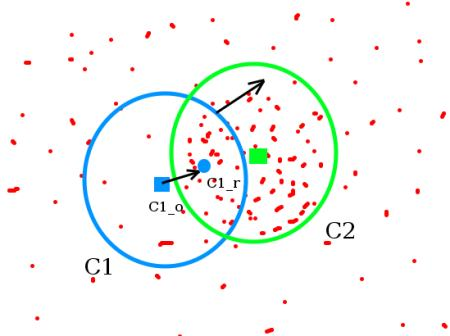

The initial window is shown in blue circle with the name "C1". Its original center is marked in blue rectangle, named "C1_o". But if you find the centroid of the points inside that window, you will get the point "C1_r" (marked in small blue circle) which is the real centroid of the window. Surely they don't match. So move your window such that the circle of the new window matches with the previous centroid. Again find the new centroid. Most probably, it won't match. So move it again, and continue the iterations such that the center of window and its centroid falls on the same location (or within a small desired error). So finally what you obtain is a window with maximum pixel distribution. It is marked with a green circle, named "C2". As you can see in the image, it has maximum number of points. The whole process is demonstrated on a static image below:

https://docs.opencv.org/3.4/meanshift_face.gif

So we normally pass the histogram backprojected image and initial target location. When the object moves, obviously the movement is reflected in the histogram backprojected image. As a result, the meanshift algorithm moves our window to the new location with maximum density.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 30-33


In [5]:
cap = cv2.VideoCapture("videos/car_racing.mp4")

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

# Define an initial tracking window for a specific object.
frame_h, frame_w = frame.shape[:2]
w = frame_w // 3  # Adjust the width of the window
h = frame_h // 5  # Adjust the height of the window
x = 10  # Adjust the x-coordinate of the top-left corner of the window
y = 400  # Adjust the y-coordinate of the top-left corner of the window
track_window = (x, y, w, h)

# Calculate the normalized HSV histogram of the initial window.
h_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(h_hist, h_hist, 0, 255, cv2.NORM_MINMAX)

# Define the termination criteria:
# 10 iterations or convergence within 1-pixel radius.
term_crit = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # if frame is read correctly ret is True
    if not success:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Perform back-projection of the HSV histogram onto the frame.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_proj = cv2.calcBackProject([hsv], [0], h_hist, [0, 180], 1)

    # Perform tracking with MeanShift.
    num_iters, track_window = cv2.meanShift(back_proj, track_window, term_crit)

    # Draw the tracking window.
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    # Display the resulting frame
    cv2.imshow('back-projection', back_proj)
    cv2.imshow('meanshift', frame)

    k = cv2.waitKey(50)
    if k == 27:  # Escape
        break
        
    # Capture a frame from the camera
    success, frame = cap.read()
    
# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

# CamShift :
The main difference is that a call
to `cv2.CamShift` returns a rectangle with a particular rotation that follows the rotation of
the object being tracked. With just a few modifications to the preceding MeanShift example,
we can instead use CamShift and draw a rotated tracking rectangle.

Did you closely watch the last result? There is a problem. Our window always has the same size whether the car is very far or very close to the camera. That is not good. We need to adapt the window size with size and rotation of the target. Once again, the solution came from "OpenCV Labs" and it is called CAMshift (Continuously Adaptive Meanshift).

It applies meanshift first. Once meanshift converges, it updates the size of the window as, s=2×√M00/256. It also calculates the orientation of the best fitting ellipse to it. Again it applies the meanshift with new scaled search window and previous window location. The process continues until the required accuracy is met.

https://docs.opencv.org/3.4/camshift_face.gif

We use the `cv2.boxPoints` function to find the vertices of the rotated tracking rectangle.

Then, we use the `cv2.polylines` function to draw the lines connecting these vertices.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 34-35


In [6]:
cap = cv2.VideoCapture("videos/car_racing.mp4")

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

# Define an initial tracking window for a specific object.
frame_h, frame_w = frame.shape[:2]
w = frame_w // 3  # Adjust the width of the window
h = frame_h // 5  # Adjust the height of the window
x = 10  # Adjust the x-coordinate of the top-left corner of the window
y = 400  # Adjust the y-coordinate of the top-left corner of the window
track_window = (x, y, w, h)

# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # if frame is read correctly ret is True
    if not success:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Perform back-projection of the HSV histogram onto the frame.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_proj = cv2.calcBackProject([hsv], [0], h_hist, [0, 180], 1)

    # Perform tracking with CamShift.
    rotated_rect, track_window = cv2.CamShift(back_proj, track_window, term_crit)

    # Draw the tracking window.
    box_points = cv2.boxPoints(rotated_rect)
    box_points = np.int0(box_points)
    cv2.polylines(frame, [box_points], True, (0, 0, 255), 2)
    
    # Display the resulting frame
    cv2.imshow('back-projection', back_proj)
    cv2.imshow('camshift', frame)

    k = cv2.waitKey(50)
    if k == 27:  # Escape
        break
        
    # Capture a frame from the camera
    success, frame = cap.read()
    
# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

C:\Users\rs admin\AppData\Local\Temp\ipykernel_15832\2100754701.py:35: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_points = np.int0(box_points)


---
# Colorspace based tracking :

Colorspace-based tracking in video processing involves utilizing different color representations (colorspaces) of an image or video frames to isolate and track specific colors or objects of interest. It's a powerful technique commonly used in computer vision tasks.

**• Colorspaces:**

Different color representations (e.g., RGB, HSV, YUV, etc.) represent colors in various ways, and each has its advantages for specific applications.
HSV Colorspace:

HSV(Hue, Saturation, Value) is often used for color-based tracking.
Hue represents the type of color (e.g., red, green, blue, etc.).
Saturation represents the vividness or purity of the color.
Value represents the brightness of the color.

**• Color Thresholding:**

Thresholding involves setting specific ranges of color values to isolate particular colors or objects.
In HSV colorspace, it's easy to define a range of hues, saturations, and values to filter for specific colors.

**• Trackbars for Adjustments:**

GUI elements (trackbars) in OpenCV can dynamically adjust the color range for tracking.
This enables real-time tweaking of color detection parameters.

**• Masking and Bitwise Operations:**

After setting the color range, a mask is created to highlight the regions where the specified color is present.
Bitwise operations can be applied to combine the mask with the original frame to isolate the desired color.

After setting the color range, a mask is created to highlight the regions where the specified color is present.
Bitwise operations can be applied to combine the mask with the original frame to isolate the desired color.

More details in :[📄OpenCV_Course.pdf](https://github.com/ZahraEk/OpenCV-Course/blob/main/OpenCV_Course.pdf) | pages 35-40

In [14]:
def on_change(x):
    pass

# Open video file
cap = cv2.VideoCapture("videos/car_racing.mp4") 

# Create a GUI window with trackbars
cv2.namedWindow("Frame")
cv2.createTrackbar("Hue Lower", "Frame", 0, 255, on_change)
cv2.createTrackbar("Saturation Lower", "Frame", 0, 255, on_change)
cv2.createTrackbar("Value Lower", "Frame", 0, 255, on_change)
cv2.createTrackbar("Hue Upper", "Frame", 0, 255, on_change)
cv2.createTrackbar("Saturation Upper", "Frame", 0, 255, on_change)
cv2.createTrackbar("Value Upper", "Frame", 0, 255, on_change)

# Get one frame to set initial values
ret, frame = cap.read()
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
cv2.imshow("Frame", frame)

while True: 
    k = cv2.waitKey(1) 
    if k == 27: 
        break

# Get the initial trackbar values
h_lower = cv2.getTrackbarPos("Hue Lower", "Frame")
s_lower = cv2.getTrackbarPos("Saturation Lower", "Frame")
v_lower = cv2.getTrackbarPos("Value Lower", "Frame")
h_upper = cv2.getTrackbarPos("Hue Upper", "Frame")
s_upper = cv2.getTrackbarPos("Saturation Upper", "Frame")
v_upper = cv2.getTrackbarPos("Value Upper", "Frame")

# Define the lower and upper range of HSV values
lower = np.array([h_lower, s_lower, v_lower]) 
upper = np.array([h_upper, s_upper, v_upper]) 

while True: 
    ret, frame = cap.read() 

    if not ret:
        break

    # Convert frame to HSV colorspace
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 

    # Create a mask using the specified range
    mask = cv2.inRange(hsv_frame, lower, upper) 

    # Apply the mask to the original frame
    res = cv2.bitwise_and(frame, frame, mask=mask) 
    res = cv2.medianBlur(res, ksize=3) 

    # Display original frame and color-detected frame
    cv2.imshow('Frame', frame)
    cv2.imshow('Color Detector', res) 

    k = cv2.waitKey(50) 
    if k == 27: 
        break 

# Release video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

print(f"Lower Range (H, S, V): {lower}")
print(f"Upper Range (H, S, V): {upper}")

Lower Range (H, S, V): [ 10 102 102]
Upper Range (H, S, V): [ 35 255 255]
